In [1]:
from classifier.training.utils import set_seed
from pathlib import Path

import pandas as pd

set_seed(42)

SRC_DATASET_ROOT = Path('./fn-content-dataset')
SRC_DATASET_NAME = 'images__actions.parquet'

In [2]:
df = pd.read_parquet(f'./../{SRC_DATASET_NAME}')
df

,file_name,69,anal_fucking,ass_licking,ass_penetration,fingering,grabbing_ass,grabbing_boobs,grabbing_hair/head,handjob,kissing,masturbation,pussy_rubbing,vaginal_fucking,vaginal_penetration,vibrating,wet_genitals,blowjob,cum,pussy_licking
1,1.jpg,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0
2,2.jpg,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
3,3.jpg,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0
4,4.jpg,0,0,0,0,0,0,0,1,1,0,0,1,0,0,0,1,1,0,0
5,5.jpg,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
625137,625137.jpg,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0
625138,625138.jpg,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0
625139,625139.jpg,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0
625140,625140.jpg,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0


In [3]:
file_names = df[['file_name']]
label_df = df.drop(['file_name'], axis=1)
label_df.shape

(280592, 19)

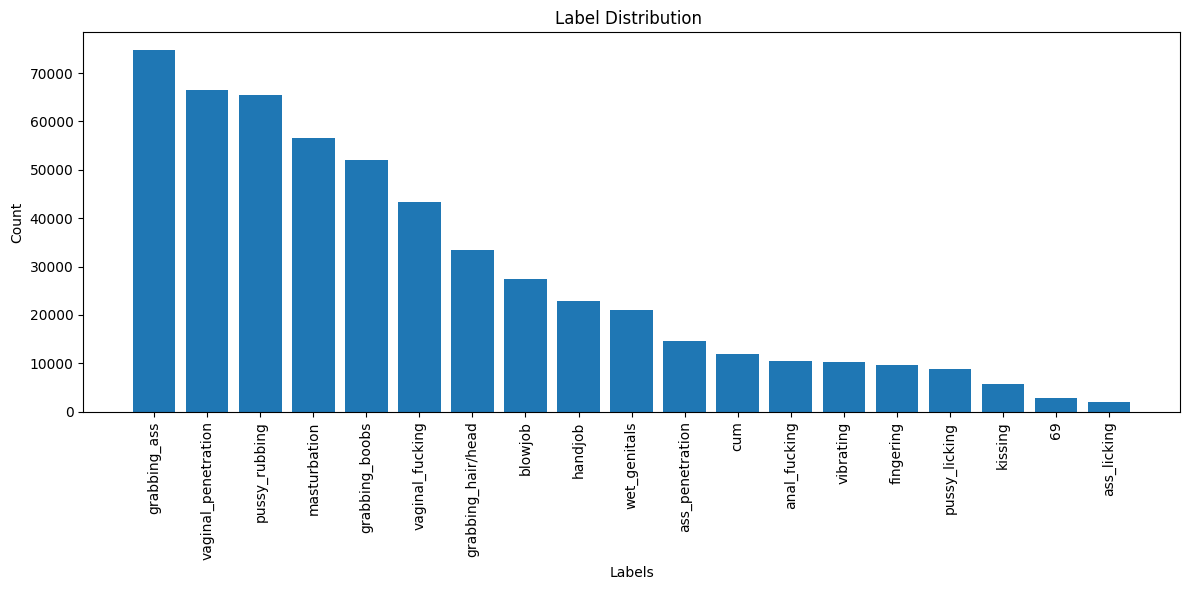

In [4]:
from notebooks.notebook_utils import plot_label_dist

filtered_counts = plot_label_dist(label_df)

# Get only the labels below a certain threshold

  0%|          | 0/19 [00:00<?, ?it/s]

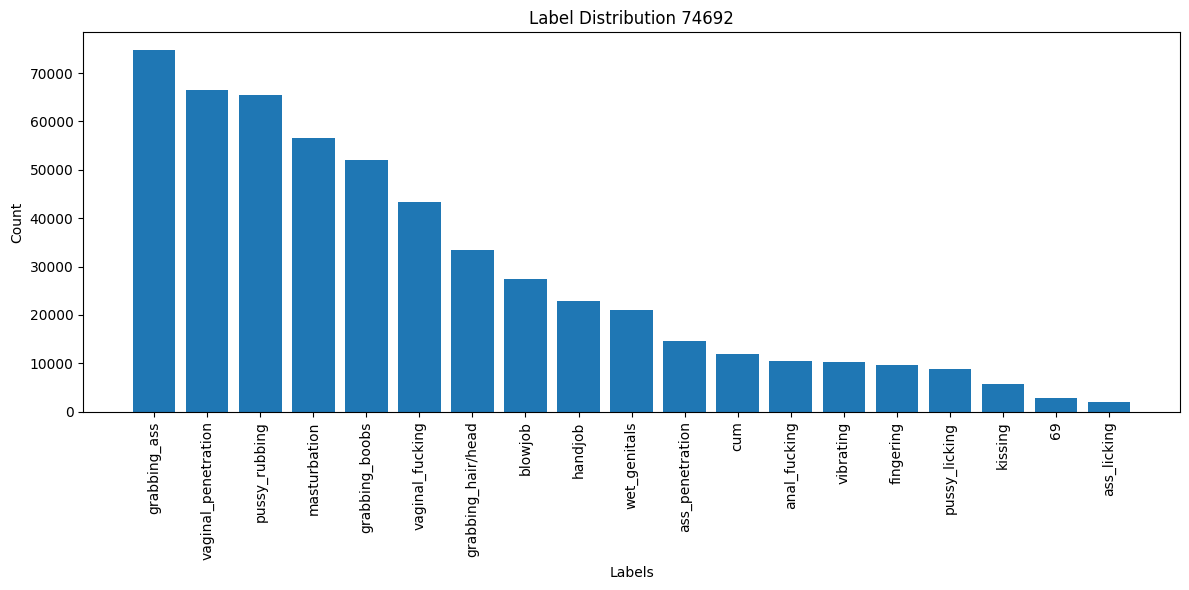

  5%|▌         | 1/19 [00:00<00:03,  4.64it/s]

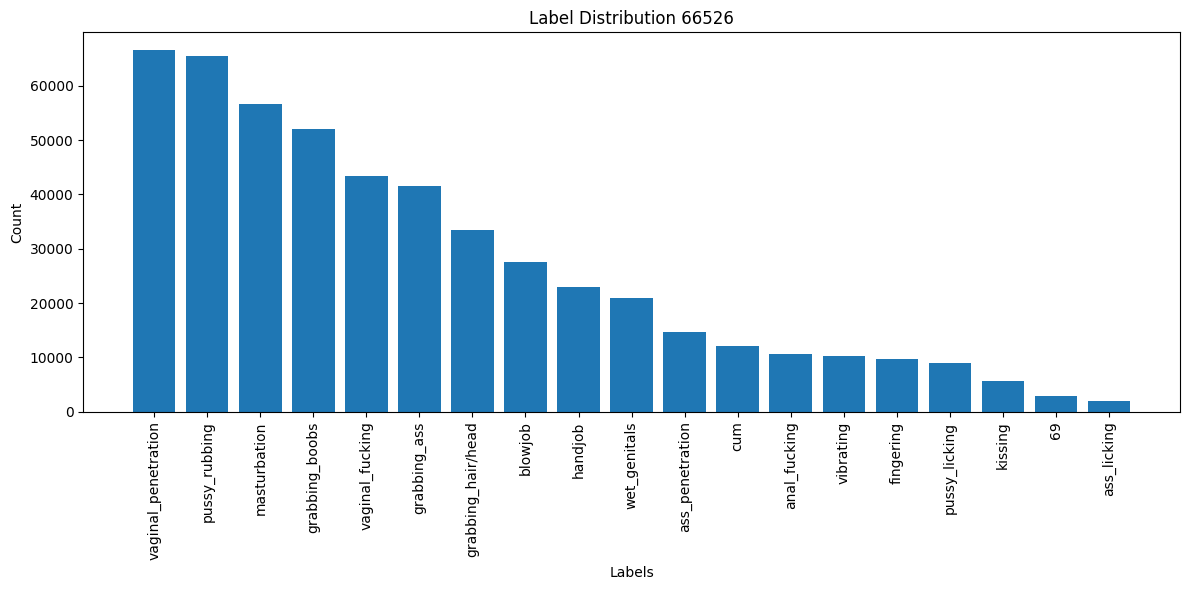

 11%|█         | 2/19 [00:00<00:03,  4.78it/s]

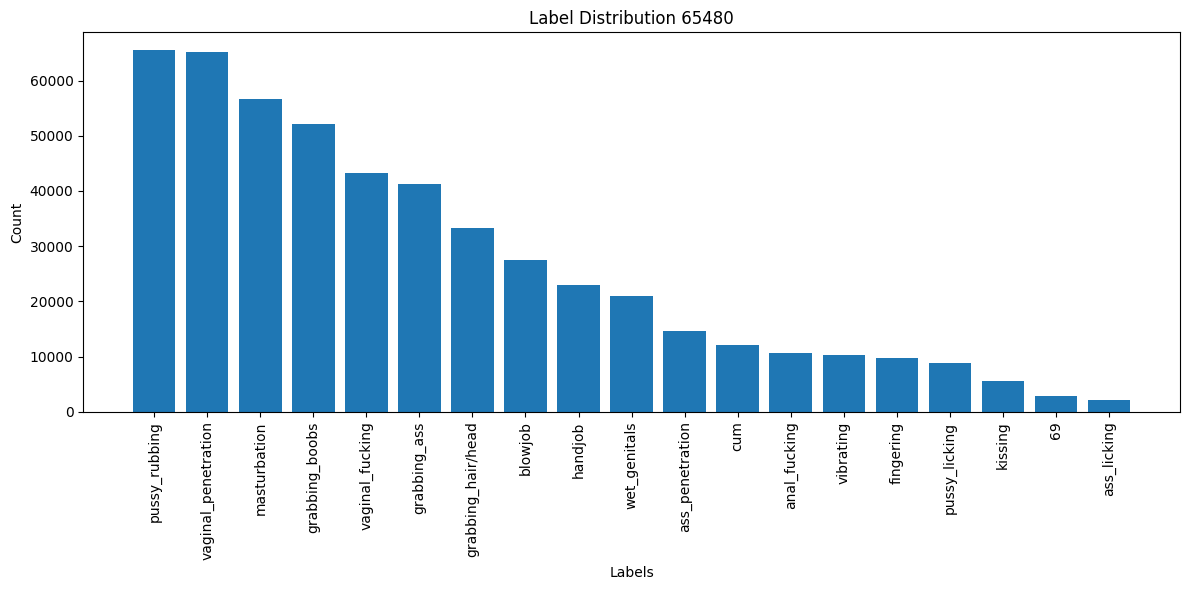

 16%|█▌        | 3/19 [00:00<00:03,  5.14it/s]

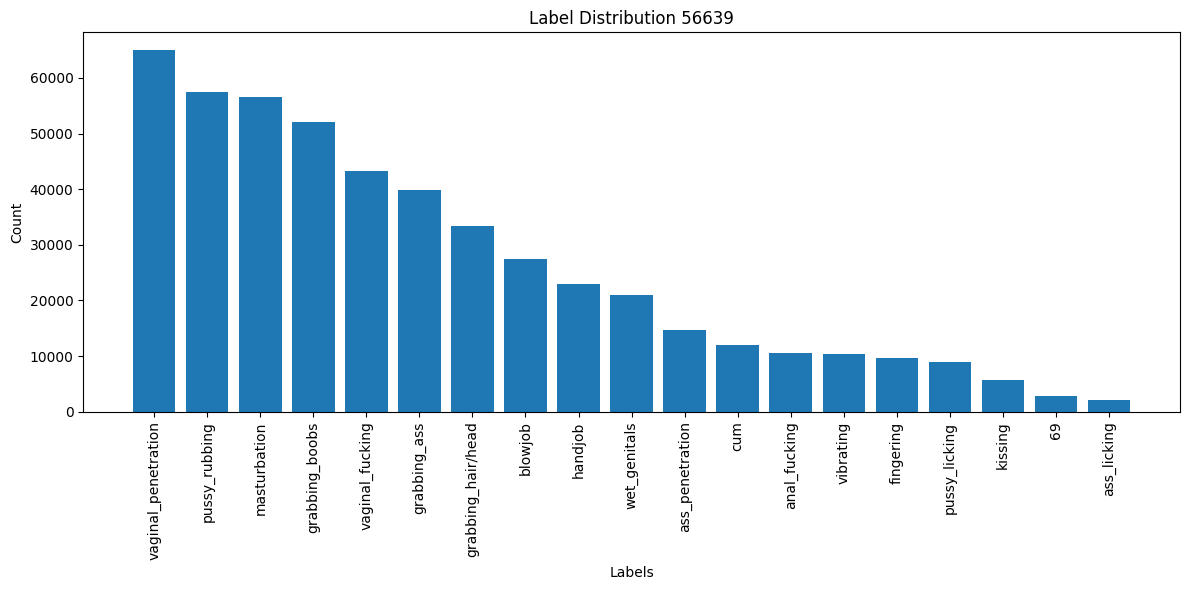

 21%|██        | 4/19 [00:00<00:02,  5.63it/s]

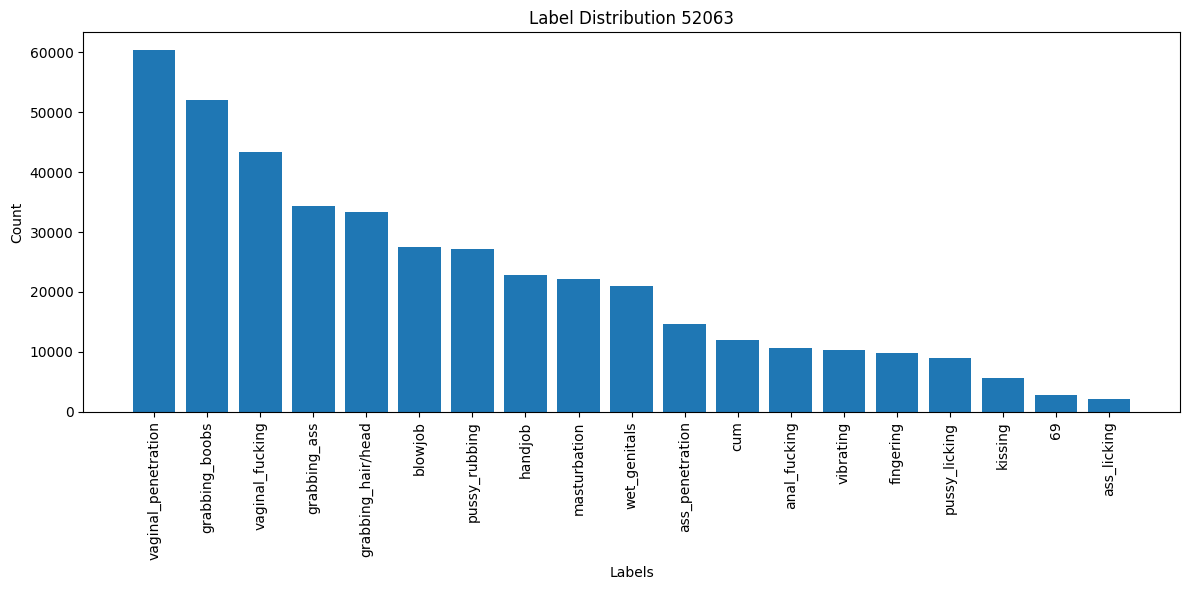

 26%|██▋       | 5/19 [00:00<00:02,  5.99it/s]

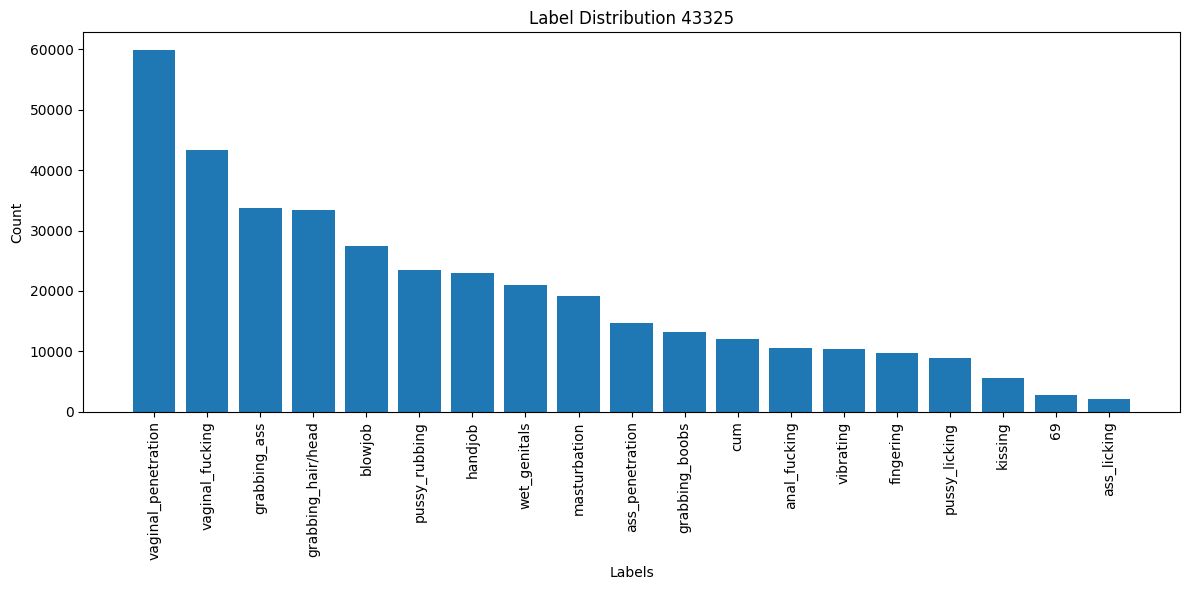

 32%|███▏      | 6/19 [00:01<00:02,  6.32it/s]

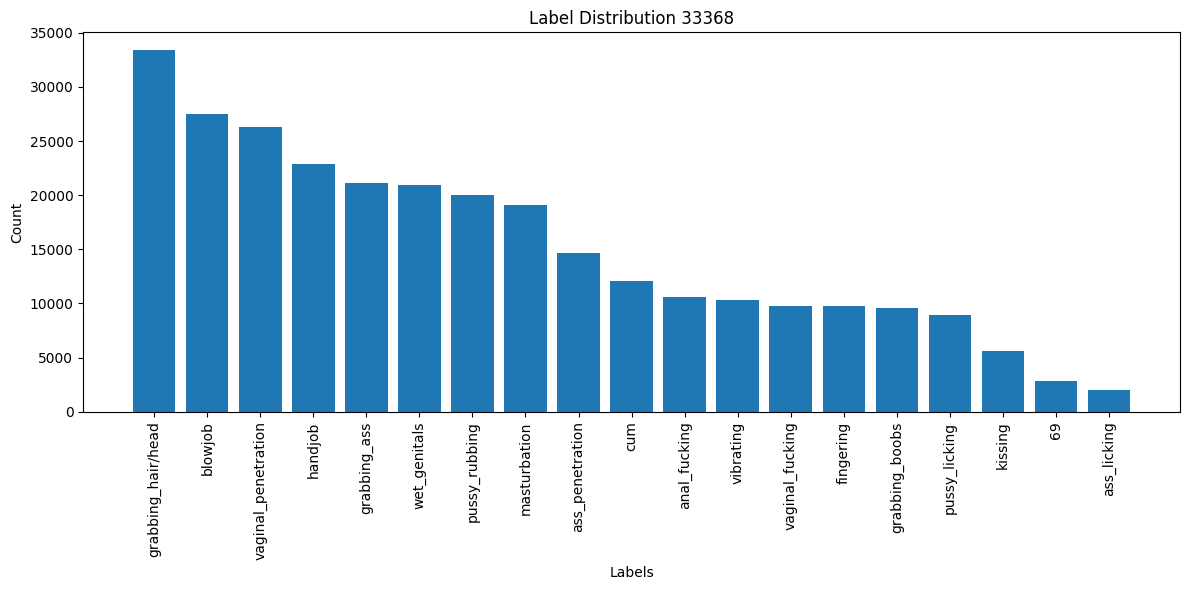

 37%|███▋      | 7/19 [00:01<00:01,  6.05it/s]

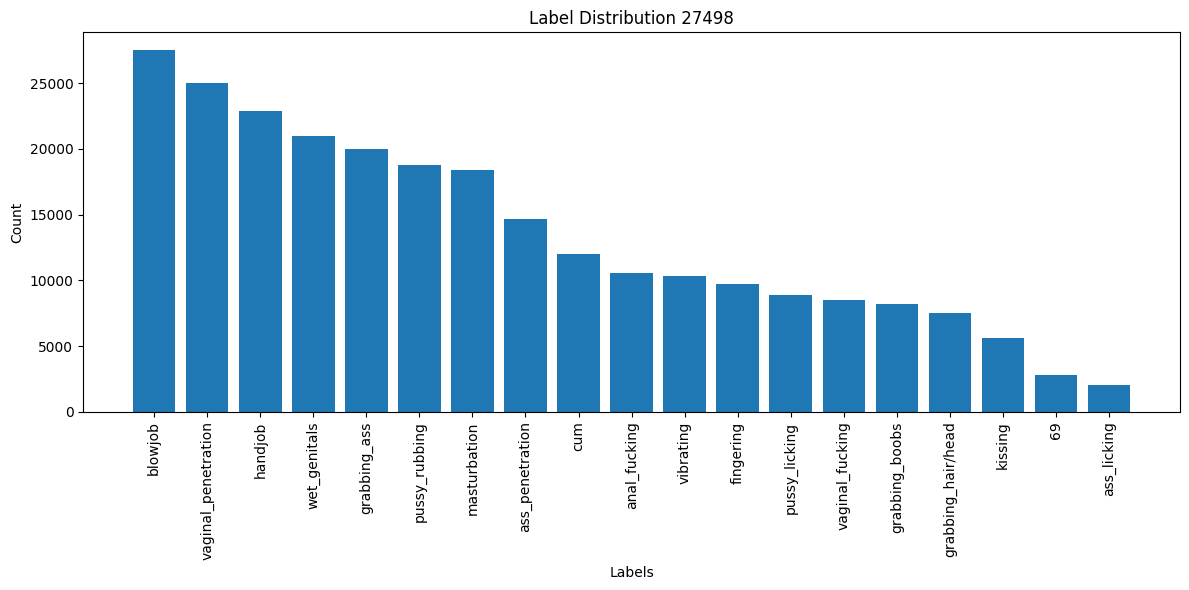

 42%|████▏     | 8/19 [00:01<00:01,  6.61it/s]

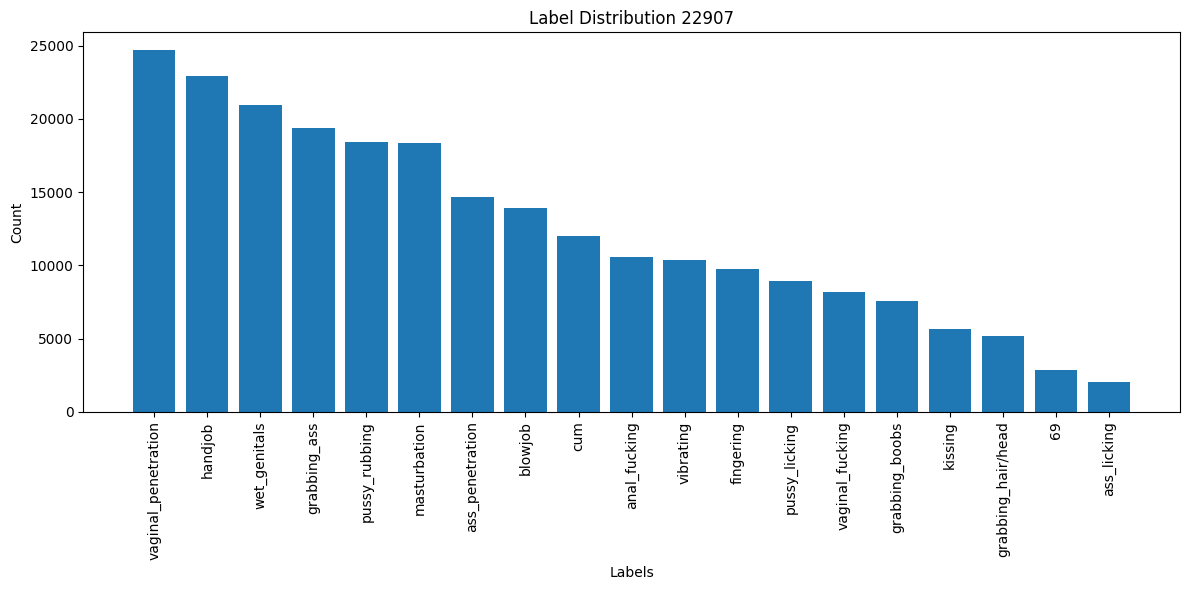

 47%|████▋     | 9/19 [00:01<00:01,  7.29it/s]

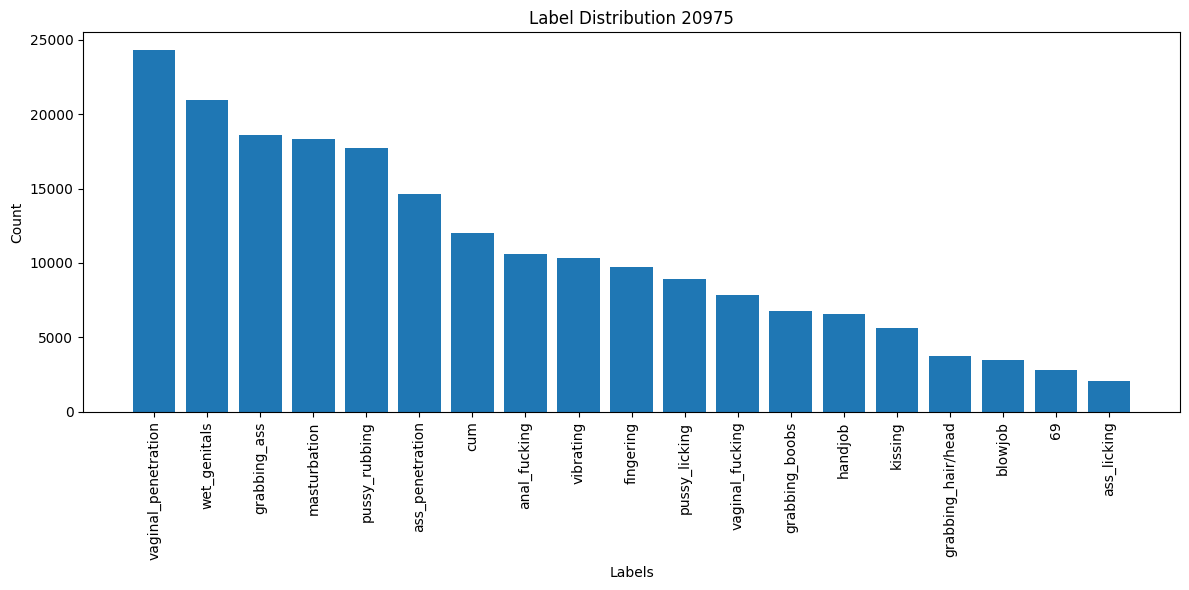

 53%|█████▎    | 10/19 [00:01<00:01,  7.94it/s]

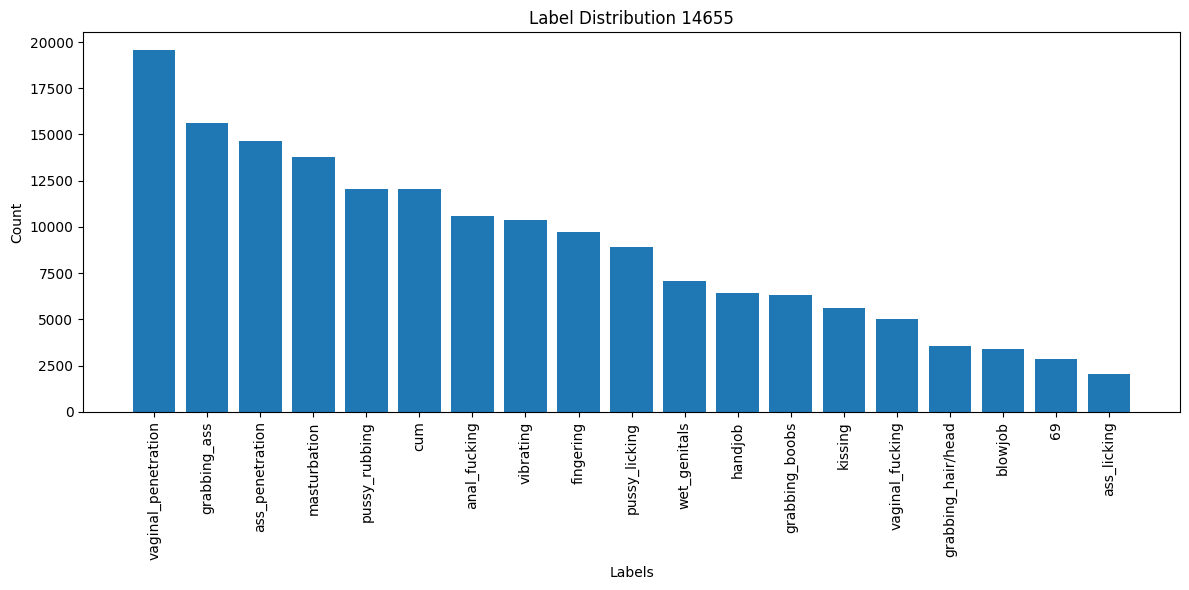

 58%|█████▊    | 11/19 [00:01<00:00,  8.23it/s]

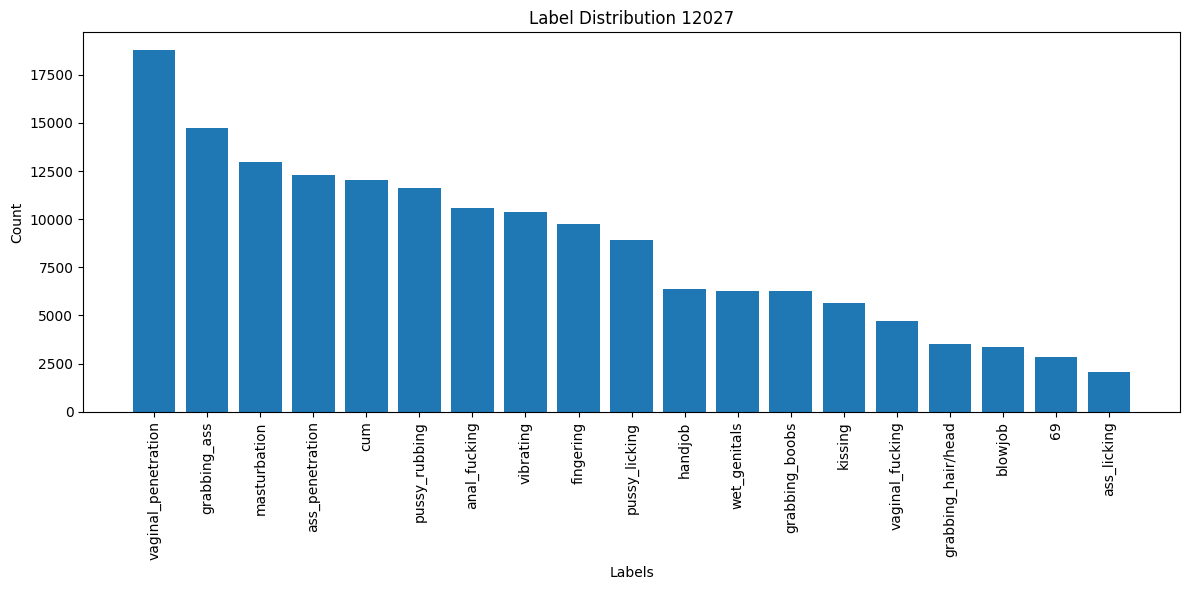

 63%|██████▎   | 12/19 [00:01<00:00,  8.52it/s]

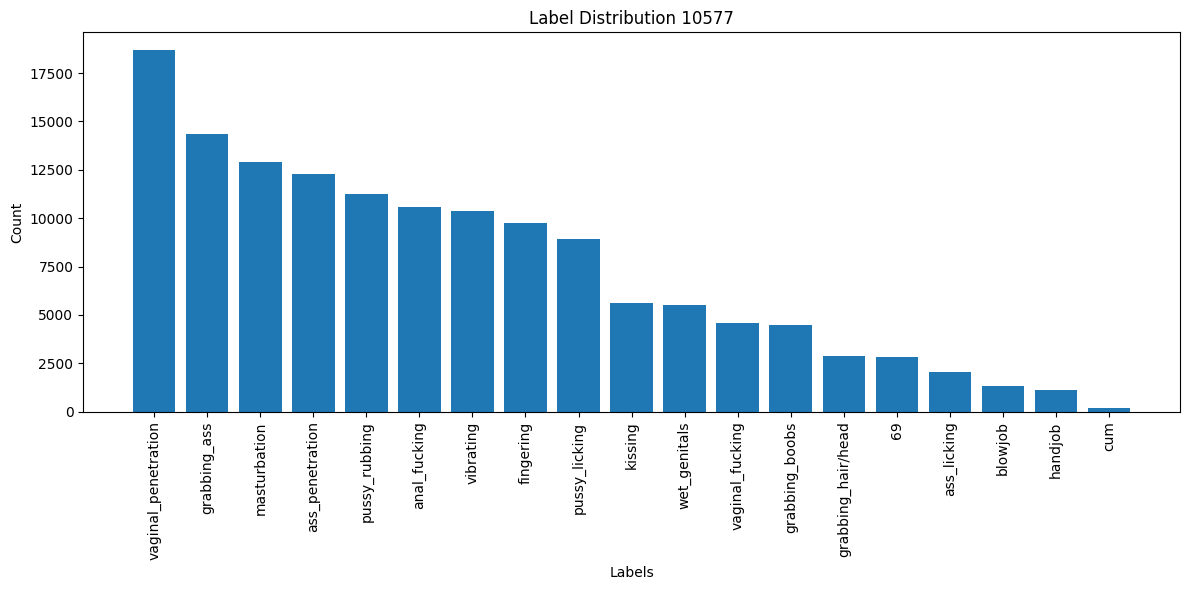

 68%|██████▊   | 13/19 [00:01<00:00,  8.89it/s]

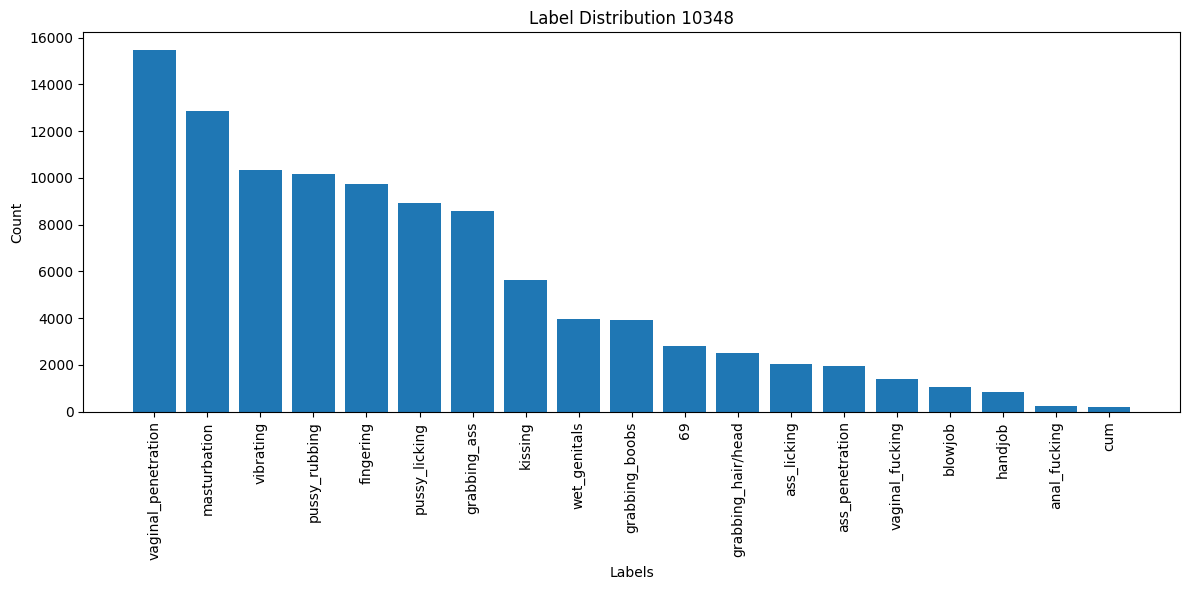

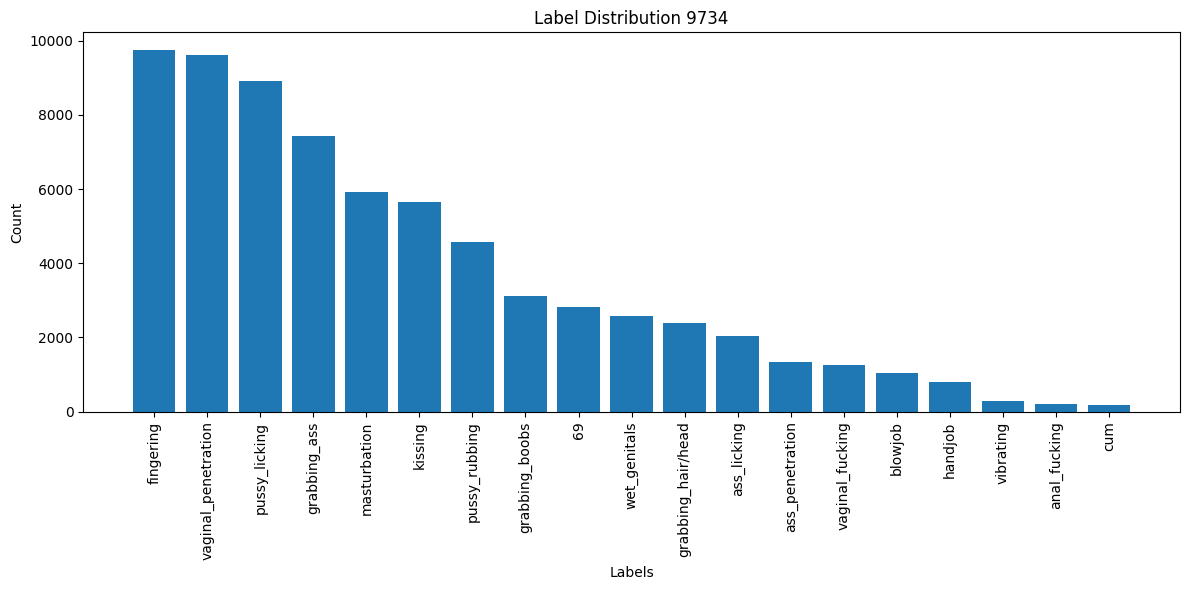

 79%|███████▉  | 15/19 [00:02<00:00,  9.69it/s]

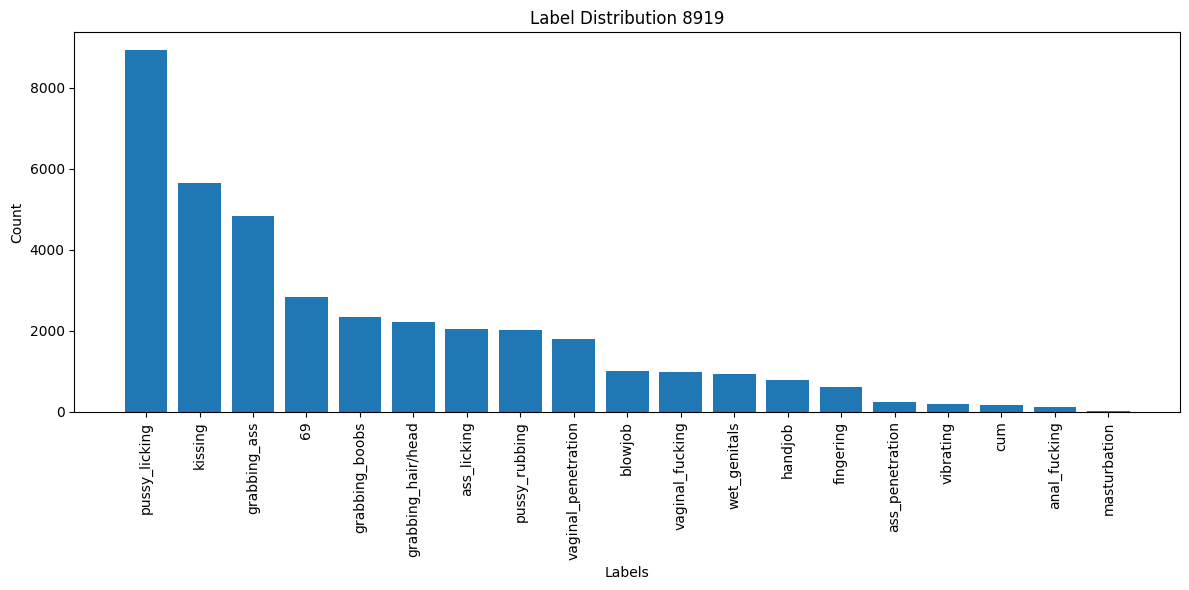

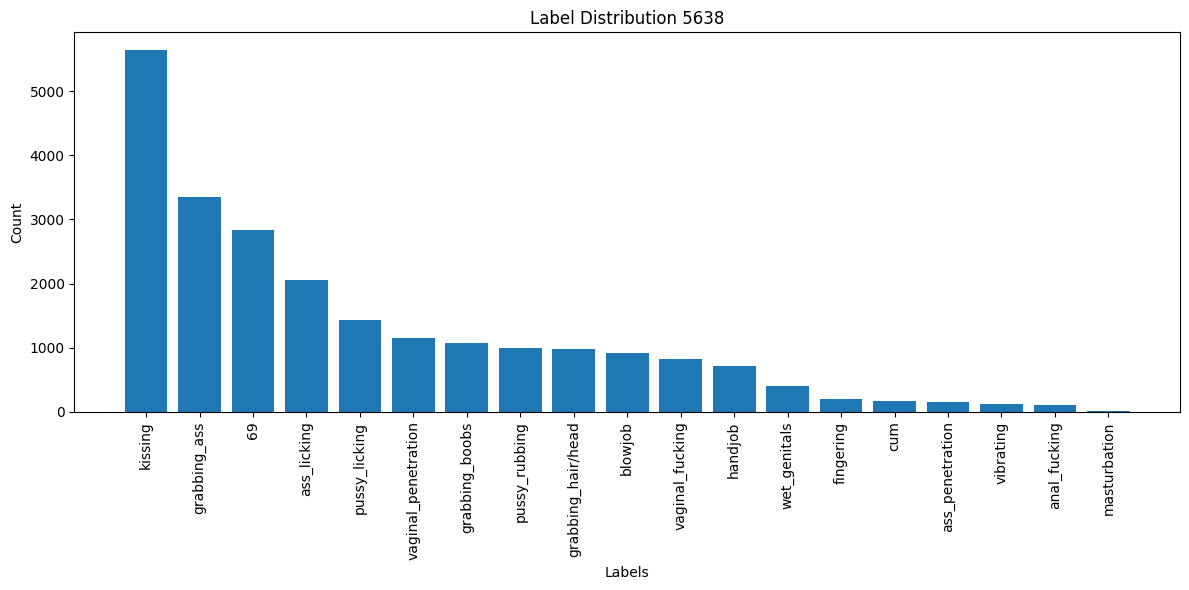

 89%|████████▉ | 17/19 [00:02<00:00,  8.42it/s]

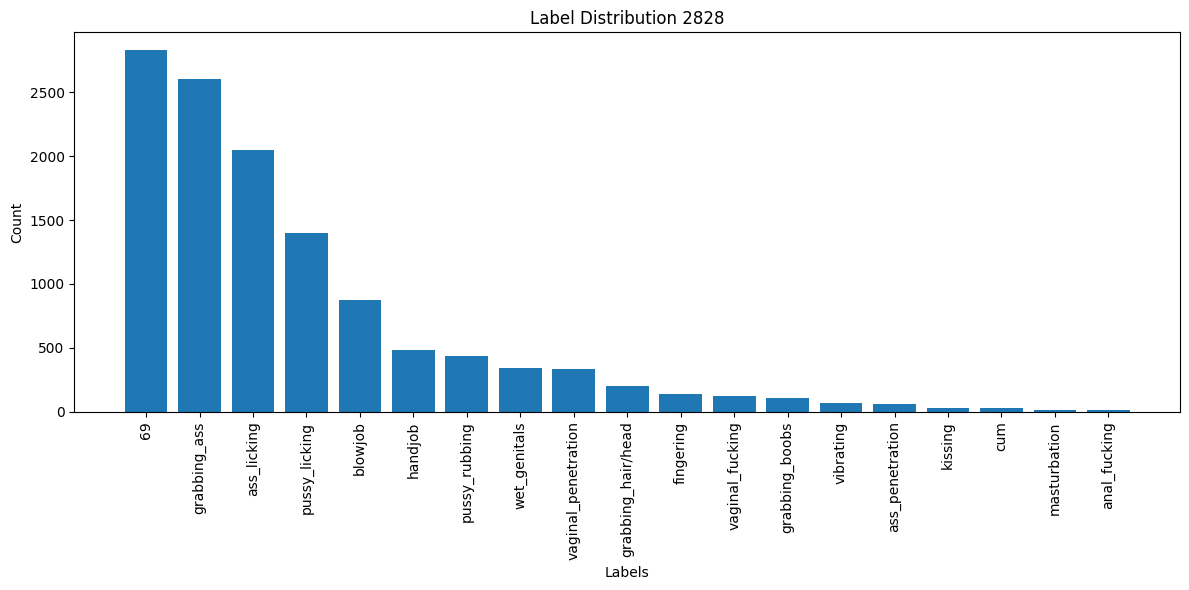

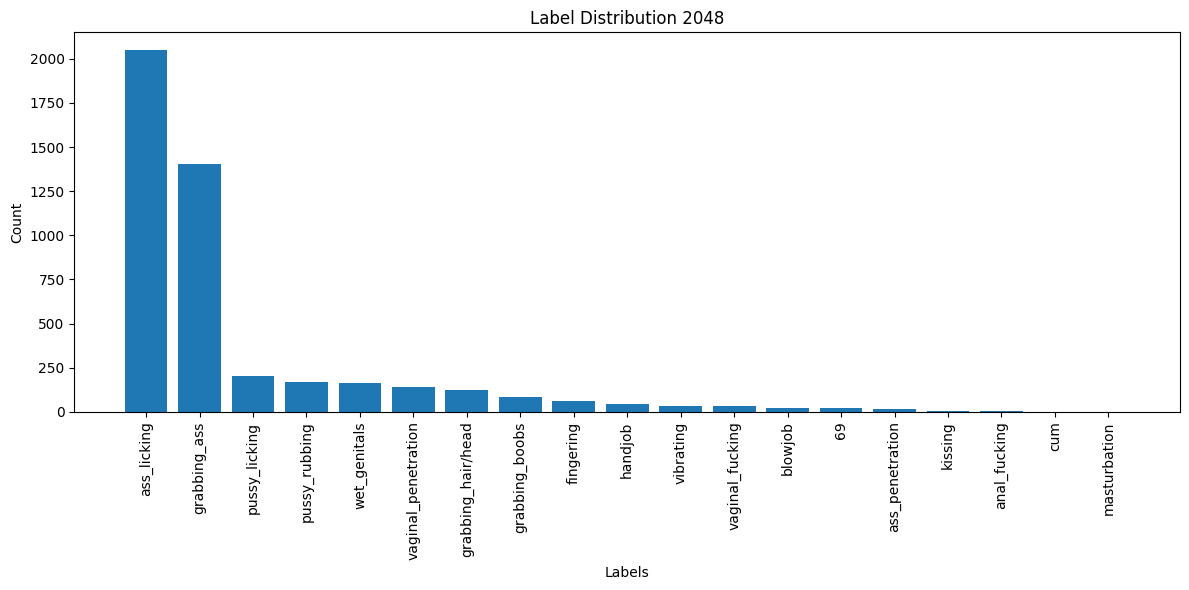

100%|██████████| 19/19 [00:02<00:00,  7.55it/s]


In [5]:
# threshold = 22907
from tqdm import tqdm

for threshold in tqdm(filtered_counts.values):
    sampled_labels = filtered_counts[filtered_counts <= threshold].index.tolist()

    original_labels = label_df.columns.tolist()

    sampled_df = label_df[sampled_labels].copy()
    sampled_df['label_count'] = sampled_df.sum(axis=1)
    _zero_labels_filter = sampled_df['label_count'] != 0
    sampled_df = sampled_df[_zero_labels_filter]
    sampled_df = sampled_df.drop(['label_count'], axis=1)

    sampled_index = sampled_df.index.tolist()
    _merge_filter = label_df.index.isin(sampled_index)
    _merged_df = label_df.loc[_merge_filter]
    _ = plot_label_dist(_merged_df, name=threshold)

In [ ]:
file_names

In [ ]:
_merged_df.shape

In [ ]:
merged_ = file_names.merge(_merged_df, left_index=True, right_index=True)
merged_.reset_index(inplace=True, drop=True)
merged_

In [ ]:
plot_label_dist(merged_.drop(['file_name'], axis=1))

In [ ]:
merged_.to_csv(SRC_DATASET_ROOT / 'balanced_action_labels.csv')

In [ ]:
from tqdm import tqdm
import shutil
from concurrent.futures import ThreadPoolExecutor

COMPILED_DATASET = SRC_DATASET_ROOT / 'compiled'
COMPILED_DATASET.mkdir(exist_ok=True)

def copy_the_image(image_path: str):
    src = SRC_DATASET_ROOT / 'images' / image_path
    dst = COMPILED_DATASET / image_path
    if dst.exists():
        return

    shutil.copy(
        src,
        dst
    )


with ThreadPoolExecutor(max_workers=16) as executor:
    futures = [
        executor.submit(copy_the_image, fp) for fp in merged_['file_name'].tolist()
    ]

    for future in tqdm(futures, total=len(futures)):
        _ = future.result()
